In [1]:
%matplotlib inline

In [2]:
import numpy as np
from netCDF4 import Dataset as ds
import matplotlib.pyplot as plt
from sympl import get_constant
from metpy.calc import moist_lapse
from metpy.units import units

Cpd = get_constant('heat_capacity_of_dry_air_at_constant_pressure', 'J/kg/degK')
Cvap = get_constant('heat_capacity_of_vapor_phase', 'J/kg/K')
g = get_constant('gravitational_acceleration', 'm/s^2')
Lv = get_constant('latent_heat_of_condensation', 'J/kg')

In [3]:
def plot_time_series(job_name):
    base_name = '/Users/haynesstephens1/uchi/research/climproj/climt_files'
    file_name = '{0}/{1}/{1}'.format(base_name, job_name)
    plot_base = '/Users/haynesstephens1/uchi/research/climproj/climproj/saved_plots'
    plot_name = '{0}/{1}/{1}_time_series.pdf'.format(plot_base, job_name)
    
    def loadData(file_name, var):
        return np.loadtxt('{0}_{1}.csv'.format(file_name, var), delimiter = ',')

    mid_levels = 28
    interface_levels = 29
    time_step_min = 10
    # SAVE STEP: KEY TO PLOTTING CORRECT TIMELINE
    save_step = 36

    time_arr = loadData(file_name, 'time')
    time_arr = np.arange(time_arr.size)*save_step*time_step_min*60
    print(time_arr.size)
    time_adj = time_arr / (3600 * 24)
    time_title = 'Days'
    lh_flux = loadData(file_name, 'surface_upward_latent_heat_flux')
    sh_flux = loadData(file_name, 'surface_upward_sensible_heat_flux')
    precip = loadData(file_name, 'convective_precipitation_rate')
    tsurf = loadData(file_name, 'surface_temperature')
    co2_ppm = loadData(file_name, 'mole_fraction_of_carbon_dioxide_in_air')[0,0] * (10**6)
    
    upwelling_longwave_flux_in_air = loadData(file_name, 'upwelling_longwave_flux_in_air')
    upwelling_shortwave_flux_in_air = loadData(file_name, 'upwelling_shortwave_flux_in_air')
    downwelling_longwave_flux_in_air = loadData(file_name, 'downwelling_longwave_flux_in_air')
    downwelling_shortwave_flux_in_air = loadData(file_name, 'downwelling_shortwave_flux_in_air')

    net_flux = (upwelling_longwave_flux_in_air +
                upwelling_shortwave_flux_in_air -
                downwelling_longwave_flux_in_air -
                downwelling_shortwave_flux_in_air)

    net_flux_surface = net_flux[:, 0]
    net_flux_toa = net_flux[:,-1]
    
    air_pressure_on_interface_levels = loadData(file_name, 'air_pressure_on_interface_levels')
    air_pressure = loadData(file_name, 'air_pressure')
    air_temperature = loadData(file_name, 'air_temperature')

    fig, axes = plt.subplots(2,2, figsize=(10,10))

    ax0 = axes[0,0]
    ln1 = ax0.plot(net_flux[-1],
             air_pressure_on_interface_levels[-1], '-o',
             markersize=3, c='k', label='Flux')
    ax0.axes.invert_yaxis()
#     ax0.set_yscale('log')
    ax0.set_xlabel('Wm$^{-2}$')
    ax0.set_ylabel('Pa')
#     ax0.grid()

    ax0b = ax0.twiny()
    ln2 = ax0b.plot(air_temperature[-1],
             air_pressure[-1], '-o', markersize=3, c='r', label='Temp')
    ax0b.set_xlabel('K')
    
    ### MOIST ADIABAT
    moist_adiabat_Tsurf = air_temperature[-1][0] * units('K')
    moist_adiabat_p = air_pressure[-1] * units('Pa')
    moist_adiabat_profile = moist_lapse(moist_adiabat_p, moist_adiabat_Tsurf)
    ln3 = ax0b.plot(moist_adiabat_profile,
             air_pressure[-1], '-o', markersize=3, c='b', label='Moist Ad')
    ###
    
    lns = ln1+ln2+ln3
    labs = [l.get_label() for l in lns]
    ax0b.legend(lns, labs, loc=2)
#     ax0b.grid()
    

    
    ax1 = axes[0,1]
    ln1 = ax1.plot(time_adj, tsurf, '-', markersize=3, c='k', label = 'Tsurf')
#     ax1.set_title('Surface Temperature')
    ax1.set_xlabel(time_title)
    ax1.set_ylabel('K')
#     ax1.grid()
    
    ax1b = ax1.twinx()
    moist_enthalpy = loadData(file_name, 'moist_enthalpy')
    ln2 = ax1b.plot(time_adj, moist_enthalpy, '-', markersize=3, c='b', label = 'Moist Enth.')
    ax1b.set_ylabel('kJm$^{-2}$')
    
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax1b.legend(lns, labs, loc=1)


    ax2 = axes[1, 0]
    ln1 = ax2.plot(time_adj, precip, '-', c='b', label = 'Precip', linewidth=2)
    ax2.set_title('Precipitation / Fluxes')
    ax2.set_xlabel(time_title)
    ax2.set_ylabel('mm/day')
#     ax2.grid()

    ax2b = ax2.twinx()
    ln2 = ax2b.plot(time_adj, lh_flux, '-.', c='y', label = 'LH Flux', linewidth=1)
    ax2b.set_ylabel('Wm$^{-2}$')
    
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax2b.legend(lns, labs, loc=1)
#     ax2b.grid()

    ax3 = axes[1, 1]
    ax3.plot(time_adj, net_flux_surface, c = 'y', label='Rad')
    ax3.plot(time_adj, sh_flux, c = 'r', label = 'SH')
    ax3.plot(time_adj, lh_flux, c = 'b', label = 'LH')
    ax3.plot(time_adj, net_flux_surface + lh_flux + sh_flux, c='#7570b3', label = 'Surf')
    ax3.plot(time_adj, net_flux_toa, c='#d95f02', label='TOA')
    ax3.plot(time_adj, 
             (downwelling_longwave_flux_in_air + downwelling_shortwave_flux_in_air)[:,-1], '--',
            label = 'INC RAD')
    ax3.set_title('Fluxes (Up is +)')
    ax3.set_xlabel(time_title)
    ax3.set_ylabel('Wm$^{-2}$')
    # ax3.set_ylim(-50, 250)
    ax3.legend()
    ax3.grid()

    fig.suptitle('CO$_2$: {0} ppm'.format(co2_ppm//1), fontsize = 10,
                 bbox=dict(facecolor='none', edgecolor='green'),
                 x=0.53, y=0.5)
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

In [4]:
### JUST CODE TO PLAY AROUND WITH THE ARRAYS
# job_name = 'test_a1_b1_c1'
# base_name = '/Users/haynesstephens1/uchi/research/climproj/climt_files'
# file_name = '{0}/{1}/{1}.nc'.format(base_name, job_name)
# nc = ds(file_name, 'r+', format='NETCDF4')
# i = 0
# dp = (nc['air_pressure_on_interface_levels'][i,:-1] - nc['air_pressure_on_interface_levels'][i,1:])
# C_tot = heat_capacity(nc['specific_humidity'][i])
# print(((C_tot * nc['air_temperature'][i] + Lv * nc['specific_humidity'][i]) * dp / g).sum())
# print(np.sum(((C_tot * nc['air_temperature'][i] + Lv * nc['specific_humidity'][i]) * dp / g)))

15769


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


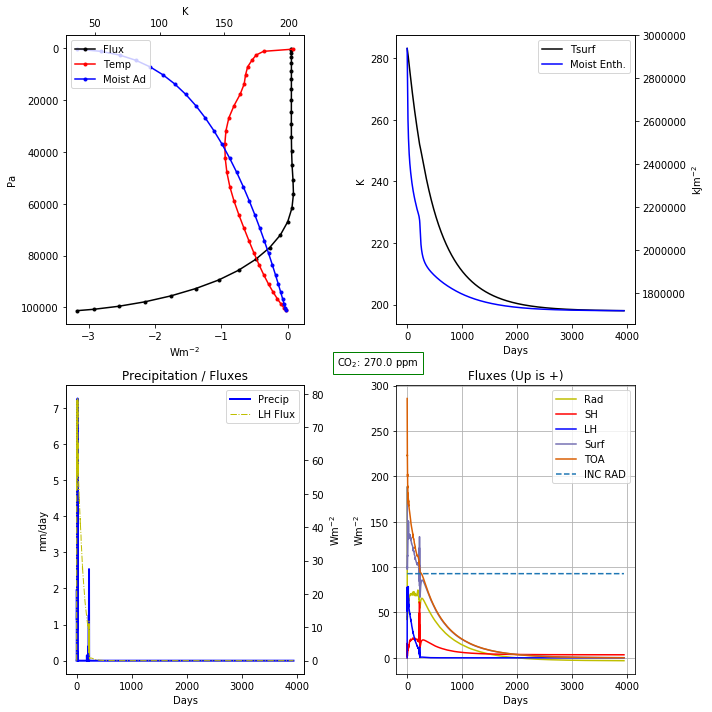

In [5]:
plot_time_series('test_a2_b1_c1')

15769


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


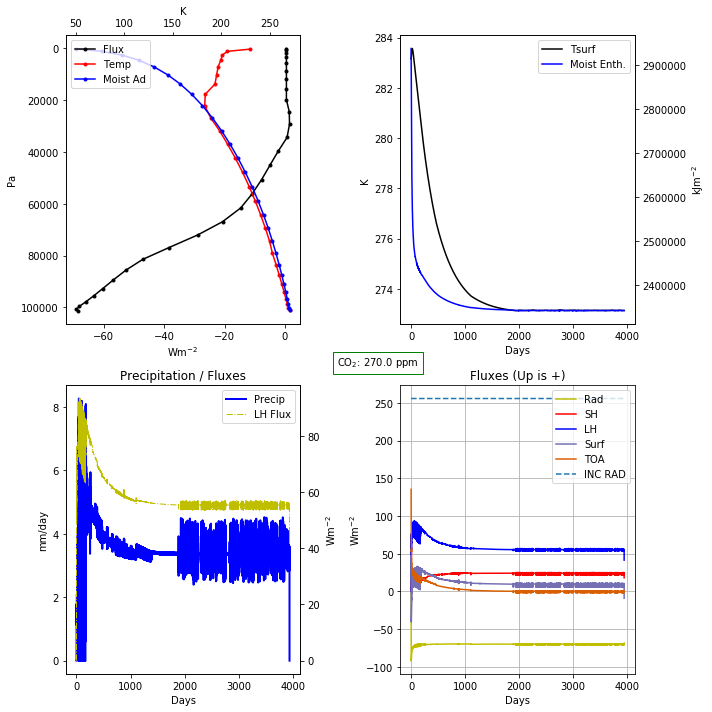

In [6]:
plot_time_series('test_a2_b1_c1_zen_32')

15769


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


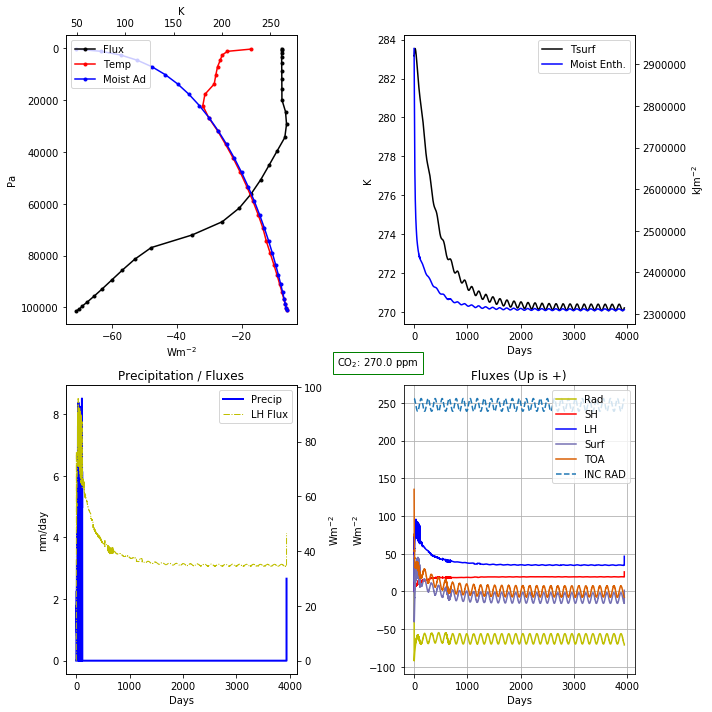

In [7]:
plot_time_series('test_a1_b1_c1_zen_32')

1576800


FileNotFoundError: [Errno 2] No such file or directory: '/Users/haynesstephens1/uchi/research/climproj/climproj/saved_plots/test_a1_b1_c1_zen_32_full/test_a1_b1_c1_zen_32_full_time_series.pdf'

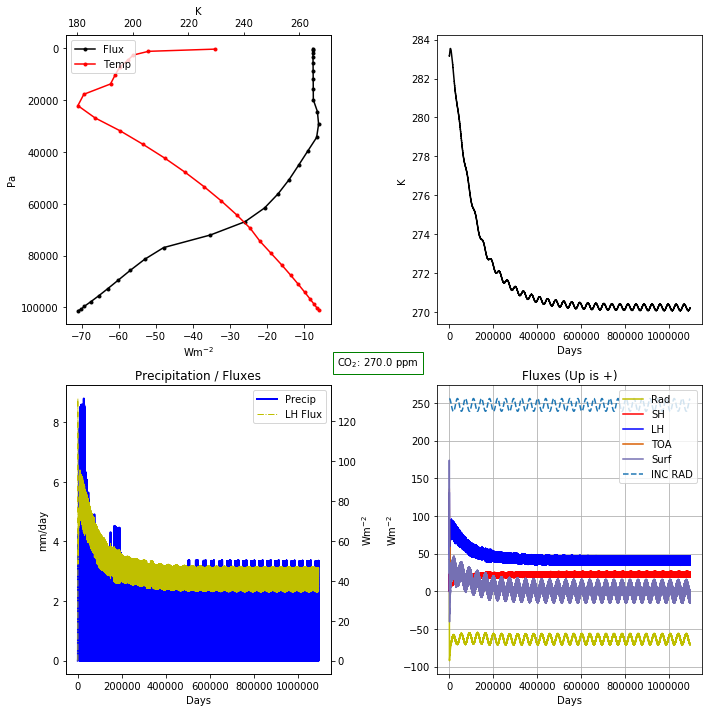

In [7]:
# DON'T RELOAD THIS PLOT
plot_time_series('test_a1_b1_c1_zen_32_full')

What's going on here? Is TOA hidden behind Surf for the net fluxes? Is there a diurnal cycle in CliMT? No right? So what would be causing this cycles (shakes) in the precip and fluxes once they reach EQ? 
Also, this time-updated run makes less sense to me that it's working properly because the precip values go down to zero, whereas the LH values never do. And maybe that makes sense with a buildup, convection, and then huge release, which could be why precip values correspond to higher LH values than the ones that are outputted. All this would be good to talk with Joy and/or Liz about. The wobble of these incoming raditive fluxes are really what make me think something's not right.  

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


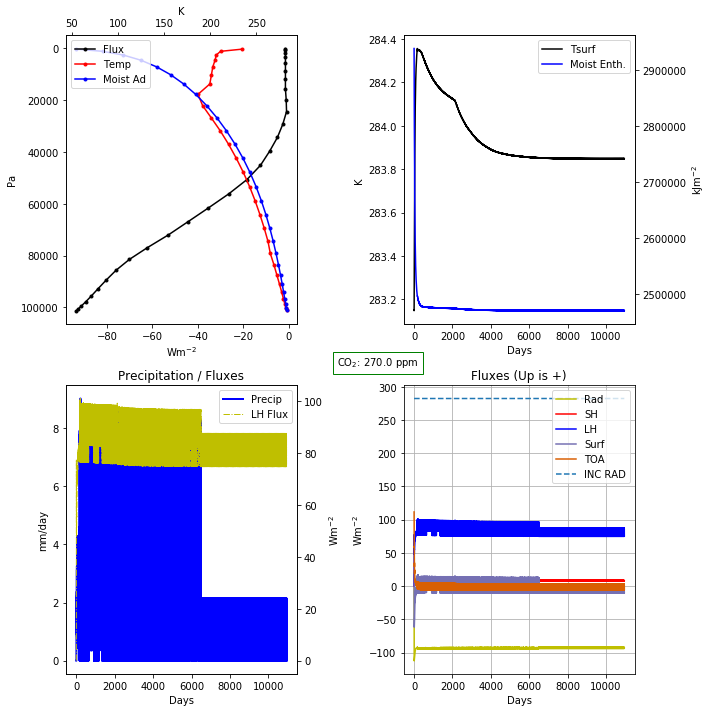

In [8]:
plot_time_series('test_a2_b1_c1_zen_32_sol_320')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


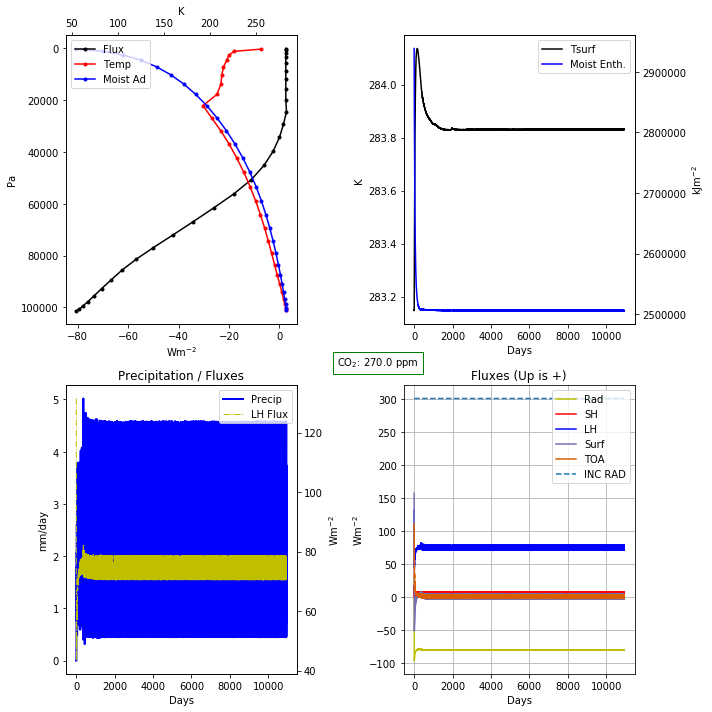

In [9]:
plot_time_series('test_a2_b1_c1_270i_939solar_usurf')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


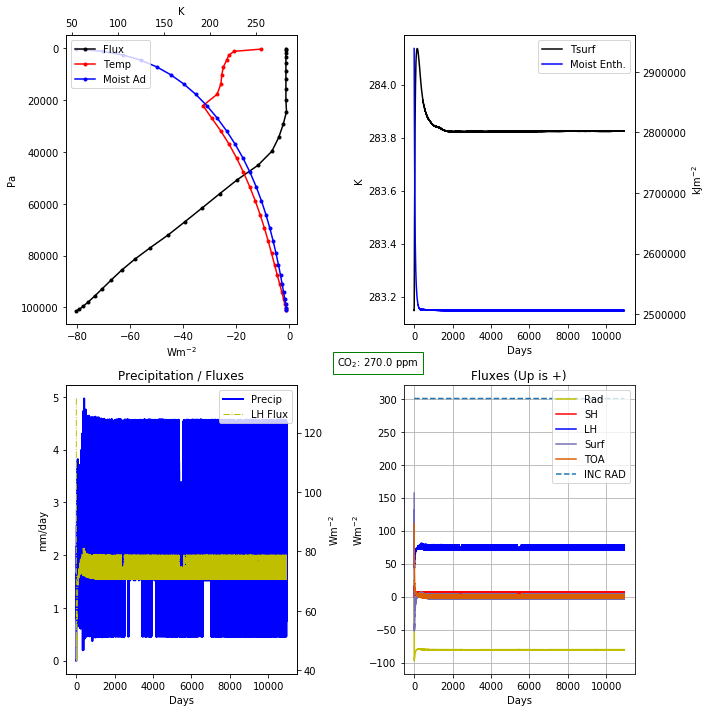

In [10]:
plot_time_series('test_a2_b1_c1_270i_939solar')

# 2019/08/27 - No-season runs

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


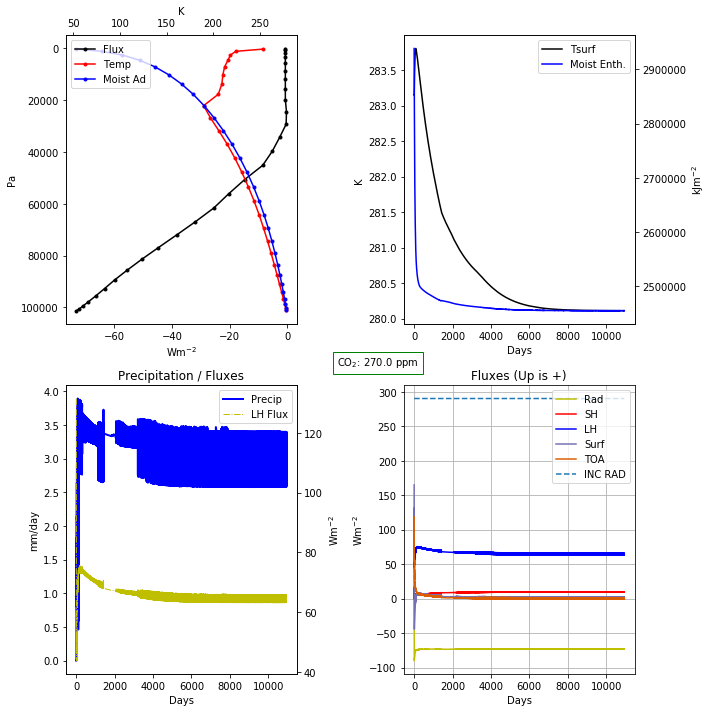

In [11]:
plot_time_series('test_a1_b1_c1_270i_939solar_usurf_noseason')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


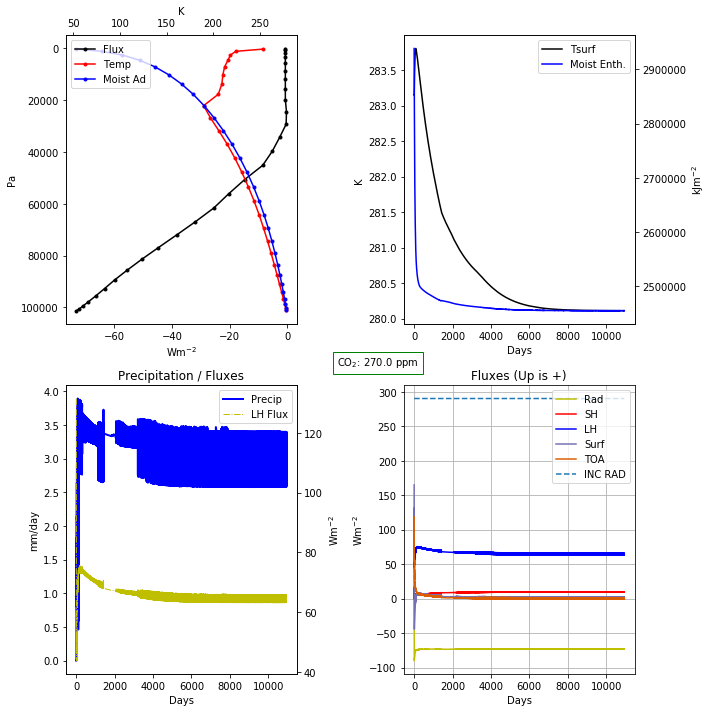

In [12]:
plot_time_series('test_a2_b1_c1_270i_939solar_usurf_noseason')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


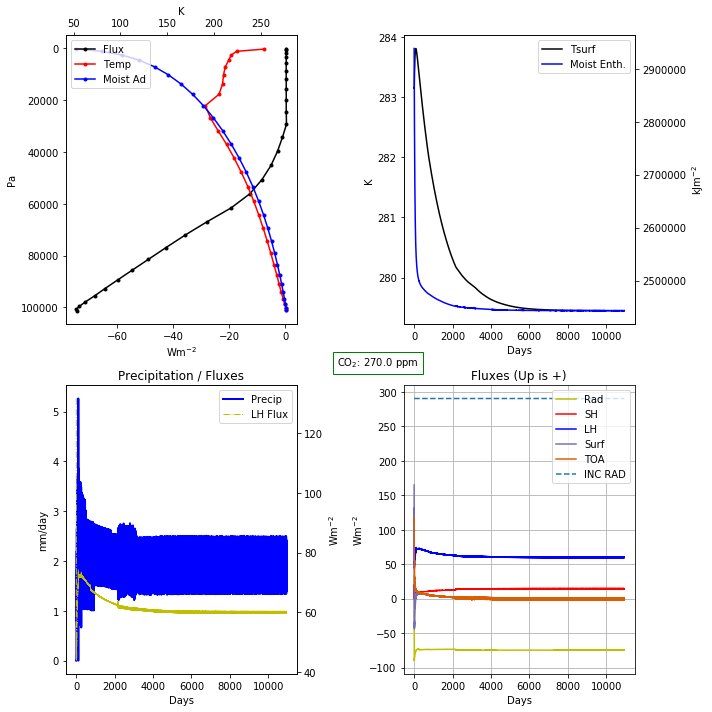

In [13]:
plot_time_series('test_a1_b1_c1_270i_939solar_dryconv_usurf_noseason')

43800


/Users/haynesstephens1/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


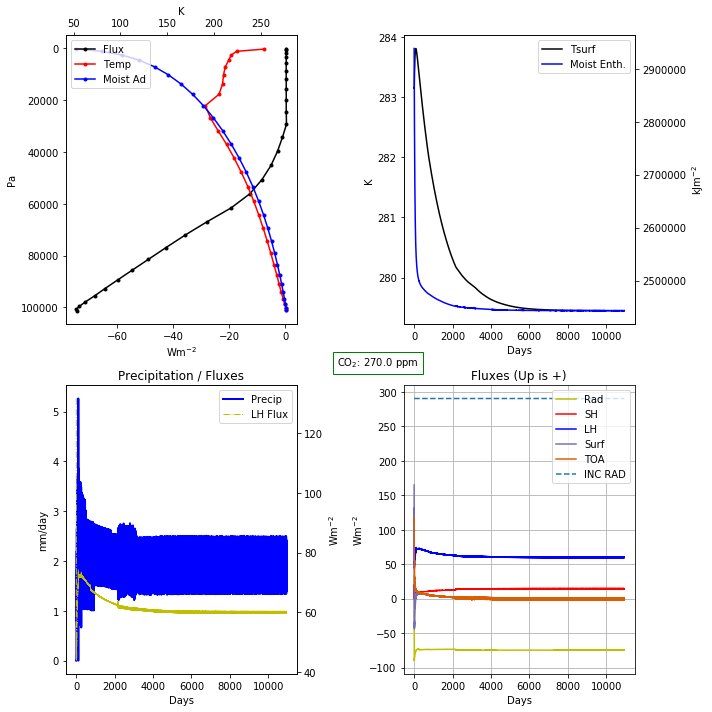

In [14]:
plot_time_series('test_a2_b1_c1_270i_939solar_dryconv_usurf_noseason')